# Homework 3

---

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve

## 1).
Split the data, stratifying on the outcome variable, survived. You should choose the proportions to split the data into. Verify that the training and testing data sets have the appropriate number of observations. Take a look at the training data and note any potential issues, such as missing data.

Why is it a good idea to use stratified sampling for this data?

It is good to use stratified sampling for the survived column of this data because the amount of the passengers who did not survive is much larger than those who did survive. Thus, by stratifying the data we ensure both the testing and training data maintains essentially the same proportion of survivors to non-survivors, preventing possible bias when training the model. 

In [101]:
# Set a seed so we can reproduce our findings
np.random.seed(100)

# Import the data and change the survived, pclass, and sex columns to category
titanic = pd.read_csv('titanic.csv')
titanic['survived'] = titanic['survived'].astype('category')
titanic['survived'] = titanic['survived'].cat.reorder_categories(['Yes', 'No'])
titanic['pclass'] = titanic['pclass'].astype('category')
titanic['sex'] = titanic['sex'].astype('category').cat.reorder_categories(['male','female'])

# Now split the data into training and testing
trainData, testData = train_test_split(titanic, test_size=0.2, stratify=titanic['survived'])

# Verify size of the training and testing data
print(f'Length of total dataset: {len(titanic)}')
print(f'Length of training dataset: {len(trainData)}')
print(f'Length of testing dataset: {len(testData)}')

# Check distribution of the survived column to verify stratification worked
print(f'\nDistribution of training dataset: {trainData["survived"].value_counts(normalize=True)}')
print(f'\nDistribution of testing dataset: {testData["survived"].value_counts(normalize=True)}')

# Find if we have any missing data in our training set
print(f'\nMissing data in training dataset: \n{trainData.isnull().sum()[trainData.isnull().sum() > 0]}')

Length of total dataset: 891
Length of training dataset: 712
Length of testing dataset: 179

Distribution of training dataset: survived
No     0.616573
Yes    0.383427
Name: proportion, dtype: float64

Distribution of testing dataset: survived
No     0.614525
Yes    0.385475
Name: proportion, dtype: float64

Missing data in training dataset: 
age         138
cabin       551
embarked      1
dtype: int64


## 2).
Using the training data set, explore/describe the distribution of the outcome variable survived.

Create a percent stacked bar chart (recommend using ggplot) with survived on the x-axis and fill = sex. Do you think sex will be a good predictor of the outcome?

Create one more percent stacked bar chart of survived, this time with fill = pclass. Do you think passenger class will be a good predictor of the outcome?

Why do you think it might be more useful to use a percent stacked bar chart as opposed to a traditional stacked bar chart?

The distribution is shown in the answer for question 1. The differences between survival rates among different passenger classes and sexes is significant enough to believe that both will be good predictors of the outcome. It might be more useful to use a percent stacked bar chart as opposed to a traditional stacked bar chart because it makes it easier to compare the relative distributions across categories by showing the proportion each categories make up of the total.

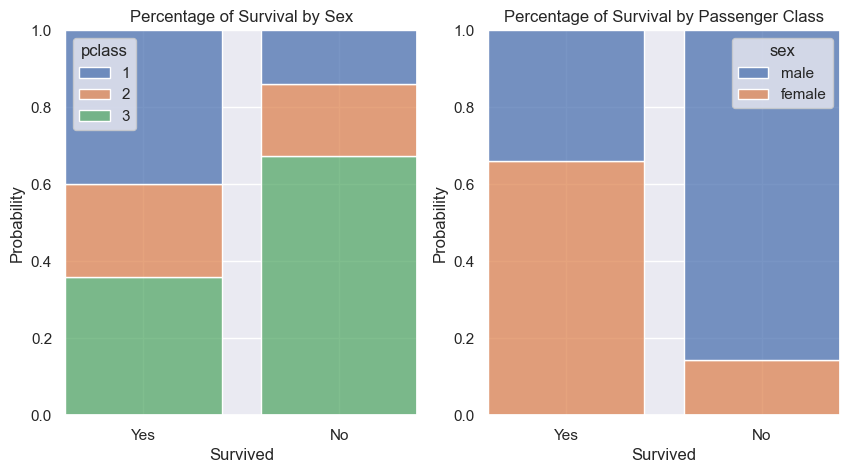

In [102]:
# Set the default theme for all graphs
sns.set_theme()

# Create our subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

# Create the first percent stacked bar chart for sex
sns.histplot(ax=ax2, data=trainData, x='survived', hue='sex', multiple='fill',stat='probability', shrink=0.8)
ax1.set_xlabel('Survived')
ax1.set_title('Percentage of Survival by Sex')

# Create the second percent stacked bar chart for pclass
sns.histplot(ax=ax1, data=trainData, x='survived', hue='pclass', multiple='fill',stat='probability', shrink=0.8)
ax2.set_xlabel('Survived')
ax2.set_title('Percentage of Survival by Passenger Class')

plt.show()

## 3).
Using the training data set, create a correlation matrix of all continuous variables. Visualize the matrix and describe any patterns you see. Are any predictors correlated with each other? Which ones, and in which direction?

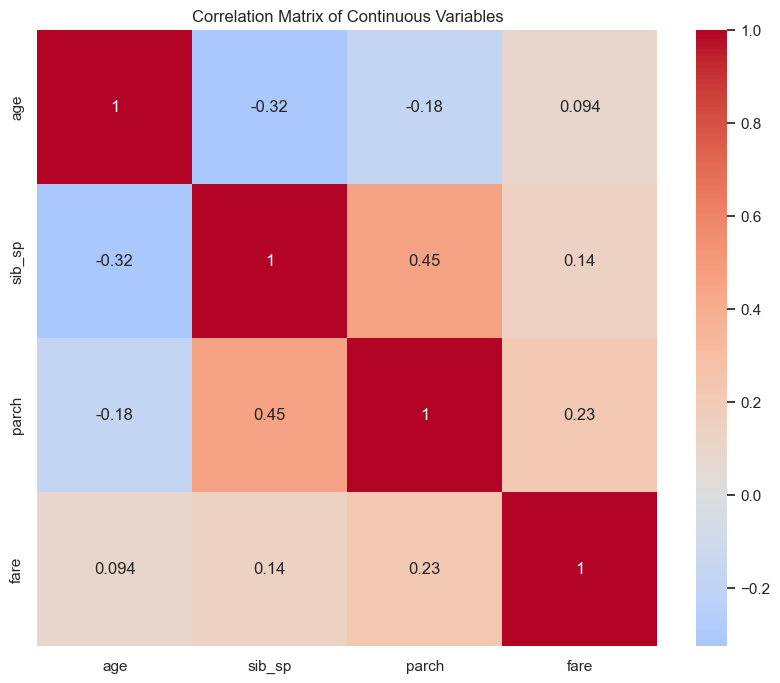

In [103]:
# Create the correlation matrix with just continuous variables
corrMatrix = trainData.select_dtypes(include=['float64','int64']).drop('passenger_id', axis=1).corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Continuous Variables')
plt.show()

We can see that both parch and sib_sp, and parch and fare are slightly positively correlated, while both age and sib_sp, and age and parch are slightly negatively correlated.

## 4).
Using the training data, create a recipe predicting the outcome variable survived. Include the following predictors: ticket class, sex, age, number of siblings or spouses aboard, number of parents or children aboard, and passenger fare.

Recall that there were missing values for age. To deal with this, add an imputation step using step_impute_linear(). Next, use step_dummy() to dummy encode categorical predictors. Finally, include interactions between:

* Sex and passenger fare, and
* Age and passenger fare.

You’ll need to investigate the tidymodels documentation to find the appropriate step functions to use.

In [104]:
# Split up our X and Y datasets
XTrainData = trainData[['pclass','sex','age','sib_sp','parch','fare']]
YTrainData = trainData['survived']

# Store the names of predictors for our preprocessing
numericPredictors = ['age','sib_sp','parch','fare']
categoricalPredictors = ['pclass','sex']
interactionTerms = ['sex_female','fare','age','fare']

# This is the same function from homework 2, it simply creates interaction terms
def interactionCreator(data, colNames):
    newColNameList = []
    for index in range(0, len(colNames) - 1, 2):
        newColName = f"{colNames[index]}_{colNames[index + 1]}"
        data[newColName] = data[colNames[index]] * data[colNames[index + 1]]
        newColNameList.append(newColName)

    return data

# Used to add our interactionCreator to the pipeline
interactionMaker = FunctionTransformer(interactionCreator, kw_args={
                        'colNames':interactionTerms}, validate=False)

# Preprocesses our data with the KNN imputer and dummy variables
preProcessor = ColumnTransformer(
    transformers=[('numeric', KNNImputer(), numericPredictors),
                  ('categorical', OneHotEncoder(sparse_output=False), categoricalPredictors)],
                  verbose_feature_names_out=False).set_output(transform='pandas')

## 5).
Specify a logistic regression model for classification using the "glm" engine. Then create a workflow. Add your model and the appropriate recipe. Finally, use fit() to apply your workflow to the training data

In [105]:
# Store our logistic regression model
logModel = LogisticRegression()

# Create our pipeline with all preprocessing, interaction makers, and the model
logPipeline = Pipeline(
    steps=[('preprocessing', preProcessor),
           ('interactions', interactionMaker),
           ('model', logModel)])

# Fit our pipeline to our training datasets
logPipeline.fit(XTrainData, YTrainData)

c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric', KNNImputer(),
                                                  ['age', 'sib_sp', 'parch',
                                                   'fare']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['pclass', 'sex'])],
                                   verbose_feature_names_out=False)),
                ('interactions',
                 FunctionTransformer(func=<function interactionCreator at 0x000001B0F85A7600>,
                                     kw_args={'colNames': ['sex_female', 'fare',
                                                           'age', 'fare']})),
                ('model', LogisticRegression())])

## 6).
Repeat Question 5, but this time specify a linear discriminant analysis model for classification using the "MASS" engine.

In [106]:
# Store our linear discriminant analysis model
ldaModel = LinearDiscriminantAnalysis()

# Create our pipeline with all preprocessing, interaction makers, and the model
ldaPipeline = Pipeline(
    steps=[('preprocessing', preProcessor),
           ('interactions', interactionMaker),
           ('model', ldaModel)])

# Fit our pipeline to our training datasets
ldaPipeline.fit(XTrainData, YTrainData)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric', KNNImputer(),
                                                  ['age', 'sib_sp', 'parch',
                                                   'fare']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['pclass', 'sex'])],
                                   verbose_feature_names_out=False)),
                ('interactions',
                 FunctionTransformer(func=<function interactionCreator at 0x000001B0F85A7600>,
                                     kw_args={'colNames': ['sex_female', 'fare',
                                                           'age', 'fare']})),
                ('model', LinearDiscriminantAnalysis())])

## 7).
Repeat Question 5, but this time specify a quadratic discriminant analysis model for classification using the "MASS" engine.

In [107]:
# Store our quadratic discriminant analysis model
qdaModel = QuadraticDiscriminantAnalysis()

# Create our pipeline with all preprocessing, interaction makers, and the model
qdaPipeline = Pipeline(
    steps=[('preprocessing', preProcessor),
           ('interactions', interactionMaker),
           ('model', qdaModel)])

# Fit our pipeline to our training datasets
qdaPipeline.fit(XTrainData, YTrainData)

c:\Users\Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric', KNNImputer(),
                                                  ['age', 'sib_sp', 'parch',
                                                   'fare']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['pclass', 'sex'])],
                                   verbose_feature_names_out=False)),
                ('interactions',
                 FunctionTransformer(func=<function interactionCreator at 0x000001B0F85A7600>,
                                     kw_args={'colNames': ['sex_female', 'fare',
                                                           'age', 'fare']})),
                ('model', QuadraticDiscriminantAnalysis())])

## 8).
Repeat Question 5, but this time specify a k-nearest neighbors model for classification using the "kknn" engine. Choose a value for k to try.

In [108]:
# Store our K-Neighbors Classifier model
kncModel = KNeighborsClassifier(n_neighbors=5)

# Create our pipeline with all preprocessing, interaction makers, and the model
kncPipeline = Pipeline(
    steps=[('preprocessing', preProcessor),
           ('interactions', interactionMaker),
           ('model', kncModel)])

# Fit our pipeline to our training datasets
kncPipeline.fit(XTrainData, YTrainData)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric', KNNImputer(),
                                                  ['age', 'sib_sp', 'parch',
                                                   'fare']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['pclass', 'sex'])],
                                   verbose_feature_names_out=False)),
                ('interactions',
                 FunctionTransformer(func=<function interactionCreator at 0x000001B0F85A7600>,
                                     kw_args={'colNames': ['sex_female', 'fare',
                                                           'age', 'fare']})),
                ('model', KNeighborsClassifier())])

## 9).
Now you’ve fit four different models to your training data.

Use predict() and bind_cols() to generate predictions using each of these 4 models and your training data. Then use the metric of area under the ROC curve to assess the performance of each of the four models.

In [123]:
# This dictionary makes it easier to showcase the predictions
models = {
    'Logistic Regression' : logPipeline,
    'Linear Discriminant Analysis' : ldaPipeline,
    'Quadratic Discriminant Analysis' : qdaPipeline,
    'K-Neighbors Classifier' : kncPipeline
}

for name, model in models.items():
    predictedProbability = model.predict_proba(XTrainData)[:,1]
    auc = roc_auc_score(YTrainData, predictedProbability)
    print(f'{name} AUC on training dataset: {auc}')

Logistic Regression AUC on training dataset: 0.8400085108513355
Linear Discriminant Analysis AUC on training dataset: 0.8478685323787829
Quadratic Discriminant Analysis AUC on training dataset: 0.5512820512820513
K-Neighbors Classifier AUC on training dataset: 0.8866763456740678


It seems like K-Neighbors Classifier did the best, with Linear Discriminant Analysis and Logistic Regression close behind, and with there being a large gap between those and Quadratic Discriminant Analysis.

## 10).
Fit all four models to your testing data and report the AUC of each model on the testing data. Which model achieved the highest AUC on the testing data?

Using your top-performing model, create a confusion matrix and visualize it. Create a plot of its ROC curve.

How did your best model perform? Compare its training and testing AUC values. If the values differ, why do you think this is so?